In [ ]:
import numpy as np
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape
from IPython.display import SVG
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer, base_filter
from keras.utils.visualize_util import model_to_dot, plot
from gensim.models.doc2vec import Word2Vec

In [ ]:
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
corpus = open(path).readlines()[0:200]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters=base_filter()+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1
dim = 100
window_size = 2

In [ ]:
def generate_data(corpus, window_size, V):
    maxlen = window_size*2
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            s = index-window_size
            e = index+window_size+1
                    
            in_words = []
            labels = []
            for i in range(s, e):
                if i != index and 0 <= i < L:
                    in_words.append([word] )
                    labels.append(words[i])

            x = np.array(in_words,dtype=np.int32)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)

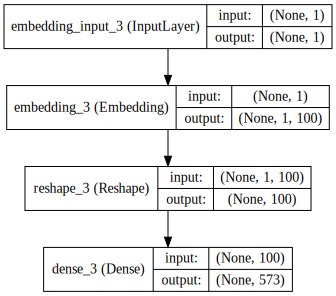

In [ ]:
skipgram = Sequential()
skipgram.add(Embedding(input_dim=V, output_dim=dim, init='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim, )))
skipgram.add(Dense(input_dim=dim, output_dim=V, activation='softmax'))
SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")

In [ ]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += skipgram.train_on_batch(x, y)

    print(ite, loss)

0 10880.5715966
1 10205.9945803
2 10074.3077066
3 9965.59868503
4 9854.57731271
5 9750.60724521
6 9657.09119558
7 9572.85030174
8 9495.95489979
9 9424.25686908


In [ ]:
f = open('vectors.txt' ,'w')
f.write(" ".join([str(V-1),str(dim)]))
f.write("\n")

1

In [ ]:
vectors = skipgram.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [ ]:
w2v = Word2Vec.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['alice'])

[('s', 0.42469197511672974),
 ('too', 0.4138217866420746),
 ('whether', 0.3842674493789673),
 ('wonderland', 0.368587851524353),
 ('in', 0.36720913648605347),
 ('that', 0.3651423156261444),
 ('adventures', 0.3534693419933319),
 ('labelled', 0.31480032205581665),
 ('yes', 0.30488651990890503),
 ('got', 0.29601991176605225)]